In [1]:
# 1.读取数据
import glob
import pandas as pd
import json

# 匹配所有 train_plan_0*.csv
files = glob.glob("../data/train_plan_*.csv")
print("找到的文件:", files)

# 读入并合并
df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

print("总数据行数:", len(df))
print("df:\n", df.head())

#获取json字符串
plans_json = df['json']
print("plans_json:\n", plans_json.iloc[0])

#字符串转json
plans_dict = []
ExecutionTimes = []
idx = 0
for json_str in plans_json:
    idx += 1
    plan_dict = json.loads(json_str)
    plans_dict.append(plan_dict['Plan'])
    try:
        ExecutionTimes.append(plan_dict['Execution Time'])
    except:
        print(f"idx: {idx} 不存在Execution Time")
        print(plan_dict)
print("plans_dict:\n", plans_dict[0])



找到的文件: ['../data/train_plan_part17.csv', '../data/train_plan_part8.csv', '../data/train_plan_part6.csv', '../data/train_plan_part3.csv', '../data/train_plan_part19.csv', '../data/train_plan_part9.csv', '../data/train_plan_part11.csv', '../data/train_plan_part1.csv', '../data/train_plan_part0.csv', '../data/train_plan_part18.csv', '../data/train_plan_part10.csv', '../data/train_plan_part12.csv', '../data/train_plan_part16.csv', '../data/train_plan_part15.csv', '../data/train_plan_part2.csv', '../data/train_plan_part14.csv', '../data/train_plan_part5.csv', '../data/train_plan_part7.csv', '../data/train_plan_part13.csv', '../data/train_plan_part4.csv']
总数据行数: 100000
df:
       id                                               json
0  85000  {"Plan": {"Node Type": "Bitmap Heap Scan", "Pa...
1  85001  {"Plan": {"Node Type": "Gather", "Parallel Awa...
2  85002  {"Plan": {"Node Type": "Hash Join", "Parallel ...
3  85003  {"Plan": {"Node Type": "Gather", "Parallel Awa...
4  85004  {"Plan": {"No

In [2]:
# 2.数据格式转换 json -> PlanNode
import sys, os
sys.path.append(os.path.abspath(".."))  # 确保当前目录加入路径

# json -> PlanNode
from models.DataPreprocessor import PlanNode, DataPreprocessor
preprocessor = DataPreprocessor()
plans_tree = preprocessor.preprocess_all(plans_dict)

In [3]:
# 3.数据格式转换 planNode -> graph 格式
# PlanNode -> edges_list, extra_info_list
def tree_to_graph(root):
    edges_list, extra_info_list = [], []

    def dfs(node, parent_idx):
        idx = len(extra_info_list)
        extra_info_list.append(node.extra_info)
        edges_list.append((idx, idx))
        if parent_idx is not None:
            edges_list.append((parent_idx, idx))
        for ch in node.children:
            dfs(ch, idx)

    dfs(root, None)
    return edges_list, extra_info_list

edges_list, matrix_plans = [], []
for i in plans_tree:
    edges_matrix, extra_info_matrix = tree_to_graph(i)
    # if len(edges_matrix) == 0:
    #     print(i)
    #     assert False
    edges_list.append(edges_matrix)
    matrix_plans.append(extra_info_matrix)

print(matrix_plans[0][0])
print(matrix_plans[0][1])



{'Node Type': 'Bitmap Heap Scan', 'Parallel Aware': False, 'Relation Name': 'movie_keyword', 'Alias': 'mk', 'Startup Cost': 11788.77, 'Total Cost': 49094.94, 'Plan Rows': 1028173, 'Plan Width': 12, 'Actual Startup Time': 41.924, 'Actual Total Time': 200.35, 'Actual Rows': 1029758, 'Actual Loops': 1, 'Recheck Cond': '(keyword_id > 17243)', 'Rows Removed by Index Recheck': 0, 'Exact Heap Blocks': 24037, 'Lossy Heap Blocks': 0}
{'Node Type': 'Bitmap Index Scan', 'Parent Relationship': 'Outer', 'Parallel Aware': False, 'Index Name': 'keyword_id_movie_keyword', 'Startup Cost': 0.0, 'Total Cost': 11531.73, 'Plan Rows': 1028173, 'Plan Width': 0, 'Actual Startup Time': 39.572, 'Actual Total Time': 39.572, 'Actual Rows': 1029758, 'Actual Loops': 1, 'Index Cond': '(keyword_id > 17243)'}


In [4]:
import pandas as pd

def plans_to_df(data: list[list[dict]]) -> pd.DataFrame:
    rows = []
    for pid, plan in enumerate(data):
        for nid, node in enumerate(plan):
            rows.append({"plan_id": pid, "node_idx": nid, **node})
    df = pd.json_normalize(rows, sep='.')

    df = df.sort_values(["plan_id", "node_idx"], kind="stable").reset_index(drop=True)
    return df

plans_df = plans_to_df(matrix_plans)
plans_df.head()


,plan_id,node_idx,Node Type,Parallel Aware,Relation Name,Alias,Startup Cost,Total Cost,Plan Rows,Plan Width,...,Peak Memory Usage,Filter,Rows Removed by Filter,Join Filter,Rows Removed by Join Filter,Merge Cond,Sort Key,Sort Method,Sort Space Used,Sort Space Type
0,0,0,Bitmap Heap Scan,False,movie_keyword,mk,11788.77,49094.94,1028173,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,Bitmap Index Scan,False,NaN,NaN,0.00,11531.73,1028173,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0,Gather,False,NaN,NaN,59038.23,292179.55,958880,136,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1,Hash Join,True,NaN,NaN,58038.23,195291.55,399533,136,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2,Index Scan,True,cast_info,ci,0.44,96872.38,1832141,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
import re
import json
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple, Any

# =========================
# 读取列统计 {name: {min, max}}
# =========================
def load_col_stats(path_or_df) -> Dict[str, Dict[str, float]]:
    if isinstance(path_or_df, str):
        stat_df = pd.read_csv(path_or_df)
    else:
        stat_df = path_or_df.copy()
    cols = {c.lower(): c for c in stat_df.columns}
    if not {"name","min","max"} <= set(cols.keys()):
        raise ValueError("统计表需要包含列: name, min, max")
    name_c, min_c, max_c = cols["name"], cols["min"], cols["max"]
    stats = {}
    for _, r in stat_df.iterrows():
        try:
            n = str(r[name_c]).strip()
            stats[n] = {"min": float(r[min_c]), "max": float(r[max_c])}
        except Exception:
            pass
    return stats

# =========================
# cond 解析：只取第一个原子条件 lhs op rhs
# =========================
_ATOM = re.compile(
    r"""
    (?P<lhs>[A-Za-z_][\w\.]*)      # 左操作数: 列名
    \s*
    (?P<op>=|<>|!=|>=|<=|>|<)      # 运算符
    \s*
    (?P<rhs>
        [A-Za-z_][\w\.]*           # 右操作数是列名
        |
        -?\d+(?:\.\d+)?            # 或者数值常量
    )
    """, re.VERBOSE
)

def _normalize_with_stats(lhs_col: str, rhs_num: float, col_stats: Dict[str, Dict[str, float]]) -> float:
    st = col_stats.get(lhs_col) or col_stats.get(lhs_col.split(".")[-1])
    if not st:
        return -1.0
    mn, mx = st["min"], st["max"]
    if mx == mn:
        return -1.0
    val = (rhs_num - mn) / (mx - mn)
    if np.isnan(val):
        return -1.0
    return float(val)

# =========================
# 列类别识别
# =========================
COND_NAME_SET = {
    "Filter", "Hash Cond", "Index Cond", "Join Filter", "Merge Cond",
    "Recheck Cond", "Sort Key"
}

def identify_cond_columns(df: pd.DataFrame, extra: List[str] | None = None) -> List[str]:
    cols = []
    for c in df.columns:
        if c in {"plan_id", "node_idx"}:
            continue
        if "cond" in c.lower() or c in COND_NAME_SET:
            cols.append(c)
    if extra:
        cols.extend(extra)
    cols = [c for c in dict.fromkeys(cols) if c in df.columns]
    return cols

def detect_numeric_columns(df: pd.DataFrame, exclude: List[str]) -> List[str]:
    numeric_cols = []
    for c in df.columns:
        if c in {"plan_id","node_idx"} or c in exclude:
            continue
        s = df[c]
        if pd.api.types.is_numeric_dtype(s):
            numeric_cols.append(c)
            continue
        ss = pd.to_numeric(s, errors="coerce")
        ok_ratio = ss.notna().mean()
        if ok_ratio >= 0.8:
            numeric_cols.append(c)
    return numeric_cols

def detect_categorical_columns(df: pd.DataFrame, exclude: List[str], numeric_cols: List[str]) -> List[str]:
    cats = []
    for c in df.columns:
        if c in {"plan_id","node_idx"} or c in exclude or c in numeric_cols:
            continue
        s = df[c]
        if pd.api.types.is_bool_dtype(s) or pd.api.types.is_string_dtype(s) or pd.api.types.is_object_dtype(s):
            cats.append(c)
    return cats

# =========================
# cond 列：拆成三列 <cond>_lhs_id / _op_id / _rhs_val，并删除原列
# =========================
def encode_cond_inplace(
    df: pd.DataFrame,
    col_stats: Dict[str, Dict[str, float]],
    cond_cols: List[str],
    op_map: Dict[str, int] | None = None,
    col_map: Dict[str, int] | None = None,
    rhs_as_col_id: bool = False  # 可选开关：True 时 rhs 为列名则写其 col_id；False 时写 -1
) -> Tuple[pd.DataFrame, Dict[str,int], Dict[str,int]]:
    df = df.copy()
    if op_map is None:  op_map = {}
    if col_map is None: col_map = {}

    for c in cond_cols:
        if c not in df.columns:
            continue

        lhs_ids, op_ids, rhs_vals = [], [], []

        for txt in df[c].astype("string"):
            if not isinstance(txt, str) or not txt.strip():
                lhs_ids.append(-1); op_ids.append(-1); rhs_vals.append(-1.0); continue

            m = _ATOM.search(txt)
            if not m:
                lhs_ids.append(-1); op_ids.append(-1); rhs_vals.append(-1.0); continue

            lhs = m.group("lhs"); op = m.group("op"); rhs = m.group("rhs")
            if lhs not in col_map: col_map[lhs] = len(col_map)
            if op  not in op_map:  op_map[op]  = len(op_map)
            lhs_id = col_map[lhs]; op_id = op_map[op]

            # 默认 -1
            rhs_val = -1.0
            try:
                rhs_num = float(rhs)
                rhs_val = _normalize_with_stats(lhs, rhs_num, col_stats)
            except ValueError:
                # rhs 是列名
                if rhs_as_col_id:
                    if rhs not in col_map:
                        col_map[rhs] = len(col_map)
                    rhs_val = float(col_map[rhs])  # 用列 id 代替
                else:
                    rhs_val = -1.0

            lhs_ids.append(int(lhs_id))
            op_ids.append(int(op_id))
            rhs_vals.append(float(-1.0 if pd.isna(rhs_val) else rhs_val))

        # 新增三列
        df[f"{c}_lhs_id"]  = lhs_ids
        df[f"{c}_op_id"]   = op_ids
        df[f"{c}_rhs_val"] = rhs_vals

        # 删除原列
        df.drop(columns=[c], inplace=True)

    return df, op_map, col_map

# =========================
# 数值/类别列：就地覆盖
# =========================
def minmax_inplace(series: pd.Series) -> Tuple[pd.Series, Dict[str, float]]:
    s = pd.to_numeric(series, errors="coerce")
    if not s.notna().any():
        return pd.Series([-1.0]*len(s), index=s.index), {"min": np.nan, "max": np.nan}
    mn = float(np.nanmin(s.values))
    mx = float(np.nanmax(s.values))
    denom = (mx - mn) if mx != mn else 1.0
    out = (s - mn) / denom
    out = out.where(~out.isna(), -1.0)
    return out, {"min": mn, "max": mx}

def factorize_inplace(series: pd.Series, known_map: Dict[str,int] | None = None) -> Tuple[pd.Series, Dict[str,int]]:
    if known_map is None:
        labels, uniques = pd.factorize(series.astype("string"), sort=True)
        mapping = {cat: i for i, cat in enumerate(uniques)}
        labels = pd.Series(labels, index=series.index, dtype="int64")
        return labels, mapping
    else:
        mapping = dict(known_map)
        next_id = (max(mapping.values()) + 1) if mapping else 0
        out = []
        for v in series.astype("string"):
            if pd.isna(v):
                out.append(-1)
            else:
                if v not in mapping:
                    mapping[v] = next_id
                    next_id += 1
                out.append(mapping[v])
        return pd.Series(out, index=series.index, dtype="int64"), mapping

# =========================
# 主流程：全部就地覆盖
# =========================
def preprocess_all_inplace(
    df: pd.DataFrame,
    stats: Dict[str, Dict[str, float]] | None,
    extra_cond_cols: List[str] | None = None,
    known_cat_maps: Dict[str, Dict[str,int]] | None = None,
    rhs_as_col_id: bool = False   # 把开关透传下来
) -> Tuple[pd.DataFrame, Dict[str, Dict], Dict[str,int], Dict[str,int]]:
    """
    - cond 列：拆成三列 <cond>_lhs_id/_op_id/_rhs_val 并删除原列；缺失→-1
    - 数值列：覆盖为 [0,1]；缺失→-1
    - 类别列：覆盖为 0..n；缺失→-1
    返回：df_out, scalers(数值列的min/max), op_map, col_map
    """
    df = df.copy()
    known_cat_maps = known_cat_maps or {}

    cond_cols = identify_cond_columns(df, extra=extra_cond_cols)

    op_map: Dict[str,int] = {}
    col_map: Dict[str,int] = {}
    if stats is None:
        stats = {}

    # cond → 三列
    df, op_map, col_map = encode_cond_inplace(
        df, stats, cond_cols, op_map, col_map, rhs_as_col_id=rhs_as_col_id
    )

    # 识别数值/类别（排除了原 cond 列，因为已被删除/替换）
    num_cols = detect_numeric_columns(df, exclude=[])
    cat_cols = detect_categorical_columns(df, exclude=[], numeric_cols=num_cols)

    scalers: Dict[str, Dict] = {}

    # 数值列：覆盖
    for c in num_cols:
        df[c], scalers[c] = minmax_inplace(df[c])

    # 类别列：覆盖
    cat_maps: Dict[str, Dict[str,int]] = {}
    for c in cat_cols:
        df[c], cat_maps[c] = factorize_inplace(df[c], known_map=known_cat_maps.get(c))

    if {"plan_id","node_idx"} <= set(df.columns):
        df = df.sort_values(["plan_id","node_idx"], kind="stable").reset_index(drop=True)

    return df, scalers, op_map, col_map

# =========================
# ==== 使用示例 ====
# =========================
stats = load_col_stats("../data/column_min_max_vals.csv")
EXTRA_COND = []
df_out, scalers, op_map, col_map = preprocess_all_inplace(
    plans_df, stats, extra_cond_cols=EXTRA_COND, rhs_as_col_id=False  # True则把 rhs 列名映射成 id 写入 rhs_val
)
print(df_out.head(3))
print("op_map:", op_map)
print("col_map size:", len(col_map))


   plan_id  node_idx  Node Type  Parallel Aware  Relation Name  Alias  \
0        0         0          0             0.0              4      4   
1        0         1          1             0.0             -1     -1   
2        1         0          3             0.0             -1     -1   

   Startup Cost  Total Cost  Plan Rows  Plan Width  ...  Filter_rhs_val  \
0      0.006505    0.008172   0.004837    0.057143  ...             0.0   
1      0.000000    0.001919   0.004837    0.000000  ...             0.0   
2      0.032576    0.048634   0.004511    0.647619  ...             0.0   

   Join Filter_lhs_id  Join Filter_op_id  Join Filter_rhs_val  \
0                 0.0                0.0                  0.0   
1                 0.0                0.0                  0.0   
2                 0.0                0.0                  0.0   

   Merge Cond_lhs_id  Merge Cond_op_id  Merge Cond_rhs_val  Sort Key_lhs_id  \
0                0.0               0.0                 0.0        

In [23]:
def df_to_plans(df: pd.DataFrame, keep_extra_cols=False) -> list[list[dict]]:
    orig_cols = [c for c in df.columns if c not in {"plan_id", "node_idx"}]
    cols = orig_cols if not keep_extra_cols else [c for c in df.columns if c not in {"plan_id", "node_idx"}]

    out = []
    for pid, g in df.sort_values(["plan_id","node_idx"], kind="stable").groupby("plan_id", sort=True):
        plan_nodes = []
        for _, row in g.sort_values("node_idx", kind="stable").iterrows():
            d = {}
            for k in cols:
                v = row[k]
                if v is None or []:
                    continue
                d[k] = v
            plan_nodes.append(d)
        out.append(plan_nodes)
    return out

new_matrix_plans = df_to_plans(df_out)
new_matrix_plans[0][0]

{'Node Type': 0.0,
 'Parallel Aware': 0.0,
 'Relation Name': 4.0,
 'Alias': 4.0,
 'Startup Cost': 0.006504745571809025,
 'Total Cost': 0.008171953988419696,
 'Plan Rows': 0.0048369335080133925,
 'Plan Width': 0.05714285714285714,
 'Actual Startup Time': 0.001465890261978713,
 'Actual Total Time': 0.0009680831000302621,
 'Actual Rows': 0.0022363870527124094,
 'Actual Loops': 0.0,
 'Rows Removed by Index Recheck': 0.0,
 'Exact Heap Blocks': 0.4704638872577804,
 'Lossy Heap Blocks': 0.0,
 'Parent Relationship': -1.0,
 'Index Name': -1.0,
 'Workers Planned': -1.0,
 'Workers Launched': -1.0,
 'Single Copy': -1.0,
 'Join Type': -1.0,
 'Inner Unique': -1.0,
 'Workers': -1.0,
 'Scan Direction': -1.0,
 'Hash Buckets': -1.0,
 'Original Hash Buckets': -1.0,
 'Hash Batches': -1.0,
 'Original Hash Batches': -1.0,
 'Peak Memory Usage': -1.0,
 'Rows Removed by Filter': -1.0,
 'Rows Removed by Join Filter': -1.0,
 'Sort Method': -1.0,
 'Sort Space Used': -1.0,
 'Sort Space Type': -1.0,
 'Recheck Cond_

In [ ]:
# # 统计信息

# from models.Utils import StatisticsInfo

# statisticsInfo = StatisticsInfo(matrix_plans, sample_threshold=100, sample_k=10).build()
# statisticsInfo.pretty_print_report()

# # 全局信息



[Node Types] 13: ['Bitmap Heap Scan', 'Bitmap Index Scan', 'BitmapAnd', 'Gather', 'Gather Merge', 'Hash', 'Hash Join', 'Index Scan', 'Materialize', 'Merge Join', 'Nested Loop', 'Seq Scan', 'Sort']

[Global MUST keys] 10: ['Actual Loops', 'Actual Rows', 'Actual Startup Time', 'Actual Total Time', 'Node Type', 'Parallel Aware', 'Plan Rows', 'Plan Width', 'Startup Cost', 'Total Cost']

[Global ALL keys] 41: ['Actual Loops', 'Actual Rows', 'Actual Startup Time', 'Actual Total Time', 'Alias', 'Exact Heap Blocks', 'Filter', 'Hash Batches', 'Hash Buckets', 'Hash Cond', 'Index Cond', 'Index Name', 'Inner Unique', 'Join Filter', 'Join Type', 'Lossy Heap Blocks', 'Merge Cond', 'Node Type', 'Original Hash Batches', 'Original Hash Buckets', 'Parallel Aware', 'Parent Relationship', 'Peak Memory Usage', 'Plan Rows', 'Plan Width', 'Recheck Cond', 'Relation Name', 'Rows Removed by Filter', 'Rows Removed by Index Recheck', 'Rows Removed by Join Filter', 'Scan Direction', 'Single Copy', 'Sort Key', 'Sor

In [26]:
# NodeVectorizer
import re, math
from collections import defaultdict
import numpy as np
import torch
from typing import List

from models.Utils import process_join_cond_field, process_index_cond_field, load_column_stats

def NodeVectorizer(matrix_plans : List[List[dict]]) -> List[List[List[List]]]:
    res = []
    for mp in matrix_plans:
        plan_matrix = []
        for node in mp:
            node_vector = [0] * len(node.keys())
            for i, k in enumerate(node.keys()):
                node_vector[i] = node[k]
            plan_matrix.append(node_vector)
        res.append(plan_matrix)
    return res

res = NodeVectorizer(new_matrix_plans)
print(len(res[0]))
print(len(res[0][0]))



2
55


In [ ]:
# 模型搭建

import torch
import torch.nn as nn
from torch_geometric.data import Data, Batch

class NodeEncoder(nn.Module):
    """
    输入: data.x 形状 [N, F_in]
    输出: node_embs [N, d_node]
    """
    def __init__(self, in_dim: int, d_node: int):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Linear(in_dim, d_node),
            nn.ReLU(),
            nn.LayerNorm(d_node),
        )
    def forward(self, x):
        return self.proj(x)

# ---- 组合总模型 ----
class PlanCostModel(nn.Module):
    """
    NodeEncoder → GATTreeEncoder → PredictionHead
    """
    def __init__(self, nodecoder: nn.Module, treeencoder: nn.Module, predict_head: nn.Module):
        super().__init__()
        self.nodecoder = nodecoder
        self.treeencoder = treeencoder
        self.predict_head = predict_head

    def forward(self, data: Data | Batch):
        """
        期望 data 里至少有:
        - x: [N, F_in]
        - edge_index: [2, E]
        - batch: [N]  指示每个节点属于哪张图
        """
        x = self.nodecoder(data.x)                                   # [N, d_node]
        g = self.treeencoder(x, data.edge_index, data.batch)         # [B, d_graph]
        y = self.predict_head(g)                                     # [B, out_dim]
        return y


from models.TreeEncoder import GATTreeEncoder
from models.PredictionHead import PredictionHead
# ---- 使用示例 ----
# 假设你的节点原始特征维度 F_in=64，节点隐层 d_node=128，图级维度 d_graph=256
F_in, d_node, d_graph = 55, 32, 64
nodecoder = NodeEncoder(F_in, d_node)
gatTreeEncoder = GATTreeEncoder(
    input_dim=d_node,      # 一定用实际特征维度
    hidden_dim=64,
    output_dim=d_graph,
    num_layers=3,
    num_heads=4,
    dropout=0.1,
    pooling="mean"
)
predict_head = PredictionHead(d_graph, out_dim=1)
model = PlanCostModel(nodecoder, gatTreeEncoder, predict_head)


In [28]:
print(type(ExecutionTimes))
print(type(res))
print(type(edges_list))
print(model)


<class 'list'>
<class 'list'>
<class 'list'>
PlanCostModel(
  (nodecoder): NodeEncoder(
    (proj): Sequential(
      (0): Linear(in_features=55, out_features=32, bias=True)
      (1): ReLU()
      (2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
  )
  (treeencoder): GATTreeEncoder(
    (convs): ModuleList(
      (0): GATConv(32, 64, heads=4)
      (1-2): 2 x GATConv(256, 64, heads=4)
    )
    (norms): ModuleList(
      (0-2): 3 x LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (output_proj): Linear(in_features=256, out_features=64, bias=True)
  )
  (predict_head): PredictionHead(
    (mlp): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=128, out_features=64, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)


In [29]:
# 4.构建数据集class
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

def coerce_x_to_tensor(x_plan, in_dim: int):
    """
    x_plan: 很深的 list（最终行向量长度= in_dim）
    变成 [N, in_dim] 的 float32 Tensor
    """
    x = torch.tensor(x_plan, dtype=torch.float32)
    assert x.numel() % in_dim == 0, f"最后一维应为 {in_dim}，拿到形状 {tuple(x.shape)}"
    x = x.view(-1, in_dim)   # 拉平成 [N, in_dim]
    return x

def coerce_edge_index(ei_like):
    """
    ei_like: list/ndarray/tensor, 形状 [2,E] 或 [E,2]
    返回规范 [2,E] 的 long Tensor
    """
    ei = torch.as_tensor(ei_like, dtype=torch.long)
    if ei.ndim != 2:
        raise ValueError(f"edge_index 需要二维，拿到 {tuple(ei.shape)}")
    if ei.shape[0] != 2 and ei.shape[1] == 2:
        ei = ei.t().contiguous()
    elif ei.shape[0] != 2 and ei.shape[1] != 2:
        raise ValueError(f"edge_index 需为 [2,E] 或 [E,2]，拿到 {tuple(ei.shape)}")
    return ei.contiguous()

def build_dataset(res, edges_list, execution_times, in_dim=16, bidirectional=False):
    assert len(res) == len(edges_list) == len(execution_times), "长度必须一致"
    data_list = []
    for i, (x_plan, ei_like, y) in enumerate(zip(res, edges_list, execution_times)):
        x = coerce_x_to_tensor(x_plan, in_dim)      # [N, in_dim]
        edge_index = coerce_edge_index(ei_like)     # [2,E]
        N = x.size(0)

        # 边索引有效性检查
        if edge_index.numel() > 0:
            if int(edge_index.min()) < 0 or int(edge_index.max()) >= N:
                raise ValueError(f"plan[{i}] 的 edge_index 越界：节点数 N={N}，但 edge_index.max={int(edge_index.max())}")

        # 可选：做成双向图（若你的 edges 只有父->子）
        if bidirectional:
            edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)

        y = torch.tensor([float(y)], dtype=torch.float32)  # 图级回归标签
        data_list.append(Data(x=x, edge_index=edge_index, y=y))
    return data_list


In [30]:
# 构建数据集
dataset = build_dataset(res, edges_list, ExecutionTimes, in_dim=F_in, bidirectional=True)
print(f"数据集大小: {len(dataset)}")
print(f"第一个样本: x.shape={dataset[0].x.shape}, edge_index.shape={dataset[0].edge_index.shape}, y={dataset[0].y}")



数据集大小: 100000
第一个样本: x.shape=torch.Size([2, 55]), edge_index.shape=torch.Size([2, 6]), y=tensor([224.4540])


In [31]:
# 5. 训练准备
from sklearn.model_selection import train_test_split
import time
import os

# 数据集划分
train_indices, temp_indices = train_test_split(
    range(len(dataset)), test_size=0.3, random_state=42
)
val_indices, test_indices = train_test_split(
    temp_indices, test_size=0.5, random_state=42
)

train_dataset = [dataset[i] for i in train_indices]
val_dataset = [dataset[i] for i in val_indices]
test_dataset = [dataset[i] for i in test_indices]

print(f"训练集: {len(train_dataset)}, 验证集: {len(val_dataset)}, 测试集: {len(test_dataset)}")

# 创建数据加载器
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"训练批次数: {len(train_loader)}, 验证批次数: {len(val_loader)}")



训练集: 70000, 验证集: 15000, 测试集: 15000
训练批次数: 2188, 验证批次数: 469


In [32]:
# 6. 训练配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)
criterion = torch.nn.MSELoss()

# 早停机制
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1

        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False

    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

early_stopping = EarlyStopping(patience=15, min_delta=0.001)


使用设备: cuda


In [34]:

# 7. 训练函数
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    num_batches = 0
    
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        # 前向传播
        pred = model(batch)
        loss = criterion(pred, batch.y)
        
        # 反向传播
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches

def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    num_batches = 0
    
    q_errors = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch)
            loss = criterion(pred, batch.y)
            total_loss += loss.item()
            num_batches += 1
            q_error = torch.maximum(pred / batch.y, batch.y / pred)
            q_errors.append(q_error.mean().item())
    print(f"Q-error: {np.mean(q_errors):.6f}")

    return total_loss / num_batches


In [35]:

# 8. 训练循环
def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, 
                early_stopping, device, num_epochs=100):
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    print("开始训练...")
    print("-" * 60)
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # 训练
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        
        # 验证
        val_loss = validate_epoch(model, val_loader, criterion, device)
        
        # 学习率调度
        scheduler.step(val_loss)
        
        # 记录损失
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # 计算时间
        epoch_time = time.time() - start_time
        
        # 打印进度
        if epoch % 5 == 0 or epoch == num_epochs - 1:
            print(f"Epoch {epoch+1:3d}/{num_epochs} | "
                  f"Train Loss: {train_loss:.6f} | "
                  f"Val Loss: {val_loss:.6f} | "
                  f"LR: {optimizer.param_groups[0]['lr']:.2e} | "
                  f"Time: {epoch_time:.2f}s")
        
        # 早停检查
        if early_stopping(val_loss, model):
            print(f"\n早停触发在第 {epoch+1} 轮")
            break
        
        # 保存最佳模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
            }, '../models/best_model.pth')
    
    print("-" * 60)
    print("训练完成!")
    print(f"最佳验证损失: {best_val_loss:.6f}")
    
    return train_losses, val_losses

# 开始训练
train_losses, val_losses = train_model(
    model, train_loader, val_loader, optimizer, scheduler, 
    criterion, early_stopping, device, num_epochs=100
)


开始训练...
------------------------------------------------------------
Q-error: 267.128972
Epoch   1/100 | Train Loss: 24978036.729319 | Val Loss: 3815164.486074 | LR: 1.00e-03 | Time: 26.87s
Q-error: 210.508884
Q-error: 169.495499
Q-error: 168.176108
Q-error: 103.750232
Q-error: 130.291857
Epoch   6/100 | Train Loss: 5503181.734789 | Val Loss: 2366108.935501 | LR: 1.00e-03 | Time: 27.23s
Q-error: 139.023072
Q-error: 49.082623
Q-error: 63.957991
Q-error: 50.712839
Q-error: 34.123669
Epoch  11/100 | Train Loss: 4133727.543933 | Val Loss: 4830328.747934 | LR: 1.00e-03 | Time: 27.98s
Q-error: 48.944190
Q-error: 51.314232
Q-error: 38.698715
Q-error: 56.788221
Q-error: 31.753003
Epoch  16/100 | Train Loss: 3673316.569123 | Val Loss: 4005798.870219 | LR: 1.00e-03 | Time: 27.79s
Q-error: 56.503715
Q-error: 45.068539
Q-error: 39.553262
Q-error: 34.619976
Q-error: 37.839588
Epoch  21/100 | Train Loss: 3232556.865570 | Val Loss: 891656.372276 | LR: 1.00e-03 | Time: 25.08s
Q-error: 63.408750
Q-erro

已加载最佳模型进行测试


/tmp/ipykernel_59083/3599755249.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../models/best_model.pth', map_location=device)



测试集评估结果:
MSE:  188023.437500
RMSE: 433.616699
MAE:  245.832550
相对误差: 42.680576


/tmp/ipykernel_59083/3599755249.py:74: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_59083/3599755249.py:74: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_59083/3599755249.py:74: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_59083/3599755249.py:74: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_59083/3599755249.py:74: UserWarning: Glyph 35777 (\N{CJK UNIFIED IDEOGRAPH-8BC1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_59083/3599755249.py:74: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_59083/3599755249.py:74: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAP

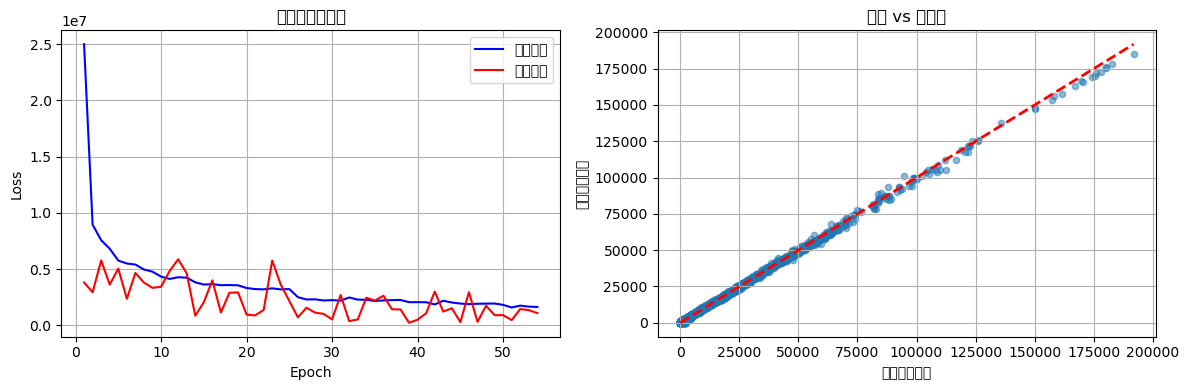

In [36]:

# 9. 测试评估
def evaluate_model(model, test_loader, device):
    model.eval()
    predictions = []
    targets = []
    
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            pred = model(batch)
            predictions.extend(pred.cpu().numpy())
            targets.extend(batch.y.cpu().numpy())
    
    predictions = np.array(predictions)
    targets = np.array(targets)
    
    # 计算评估指标
    mse = np.mean((predictions - targets) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(predictions - targets))
    
    # 计算相对误差
    relative_error = np.mean(np.abs((predictions - targets) / (targets + 1e-8)))
    
    print("\n" + "="*50)
    print("测试集评估结果:")
    print("="*50)
    print(f"MSE:  {mse:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE:  {mae:.6f}")
    print(f"相对误差: {relative_error:.6f}")
    print("="*50)
    
    return predictions, targets, {'mse': mse, 'rmse': rmse, 'mae': mae, 'relative_error': relative_error}

# 加载最佳模型进行测试
try:
    checkpoint = torch.load('../models/best_model.pth', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print("已加载最佳模型进行测试")
except FileNotFoundError:
    print("未找到保存的模型，使用当前模型进行测试")

predictions, targets, metrics = evaluate_model(model, test_loader, device)

# 10. 可视化训练过程和结果
import matplotlib.pyplot as plt

def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(12, 4))
    
    # 训练损失曲线
    plt.subplot(1, 2, 1)
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'b-', label='训练损失')
    plt.plot(epochs, val_losses, 'r-', label='验证损失')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('训练和验证损失')
    plt.legend()
    plt.grid(True)
    
    # 预测 vs 真实值
    plt.subplot(1, 2, 2)
    plt.scatter(targets, predictions, alpha=0.5, s=20)
    min_val = min(targets.min(), predictions.min())
    max_val = max(targets.max(), predictions.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    plt.xlabel('真实执行时间')
    plt.ylabel('预测执行时间')
    plt.title('预测 vs 真实值')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('../results/training_results.png', dpi=300, bbox_inches='tight')
    plt.show()

# 创建结果目录
os.makedirs('../results', exist_ok=True)
os.makedirs('../models', exist_ok=True)

# 绘制结果
plot_training_history(train_losses, val_losses)


In [ ]:

# 11. 模型保存和加载工具函数
def save_model_with_metadata(model, filepath, metadata=None):
    """保存模型和相关元数据"""
    save_dict = {
        'model_state_dict': model.state_dict(),
        'model_config': {
            'F_in': F_in,
            'd_node': d_node,
            'd_graph': d_graph,
        },
        'training_metadata': metadata or {}
    }
    torch.save(save_dict, filepath)
    print(f"模型已保存到: {filepath}")

def load_model_with_metadata(filepath, model_class, device='cpu'):
    """加载模型和元数据"""
    checkpoint = torch.load(filepath, map_location=device)
    
    # 重建模型
    config = checkpoint['model_config']
    nodecoder = NodeEncoder(config['F_in'], config['d_node'])
    gatTreeEncoder = GATTreeEncoder(
        input_dim=config['d_node'],
        hidden_dim=64,
        output_dim=config['d_graph'],
        num_layers=3,
        num_heads=4,
        dropout=0.1,
        pooling="mean"
    )
    predict_head = PredictionHead(config['d_graph'], out_dim=1)
    model = PlanCostModel(nodecoder, gatTreeEncoder, predict_head)
    
    # 加载权重
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    
    return model, checkpoint.get('training_metadata', {})

# 保存最终模型
final_metadata = {
    'train_size': len(train_dataset),
    'val_size': len(val_dataset),
    'test_size': len(test_dataset),
    'final_metrics': metrics,
    'training_epochs': len(train_losses)
}

save_model_with_metadata(model, '../models/final_model.pth', final_metadata)

print("\n训练完成! 模型已保存，结果已可视化。")


模型已保存到: ../models/final_model.pth

训练完成! 模型已保存，结果已可视化。
